In [2]:
import numpy as np
from skimage import io, draw, measure, morphology
from matplotlib import pyplot as plt
import torch

import tqdm
import time
from multiprocessing import Pool
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata, CubicSpline

from papyrus_matching.train import LitPapyrusTR
from loader.inference import InferenceDataset


In [2]:
%cd ..

/raid/homes/nicola.messina/workspace/papyri/papyrus-matching


/raid/homes/nicola.messina/anaconda3/envs/papyri/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
root = 'data/toy_fragments'
image_name_a = root + "/test_fragment_easy1_L.png"
image_name_b = root + "/test_fragment_easy1_R.png" # "/test_fragment_hard1_L.png"

from torchvision import transforms as T
transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
mask_transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
dset = InferenceDataset(image_name_a, image_name_b, pad=20, perimeter_points_distance=128, transform=transf, mask_transform=mask_transf, return_final_image=True)

In [5]:
# load the model
model_path = "runs/lightning_logs/version_0/checkpoints/epoch=3-step=2576.ckpt"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = LitPapyrusTR.load_from_checkpoint(model_path)
encoder = model.eval().to(device)

Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to /home/nicolamessina/.cache/torch/hub/checkpoints/maxvit_t-bc5ab103.pth


100%|██████████| 119M/119M [00:01<00:00, 104MB/s]  


[INFO] Trainable parameters: 8964768/30408712 (29.48%)


In [6]:
len(dset)

110

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [14:26<00:00,  7.88s/it]


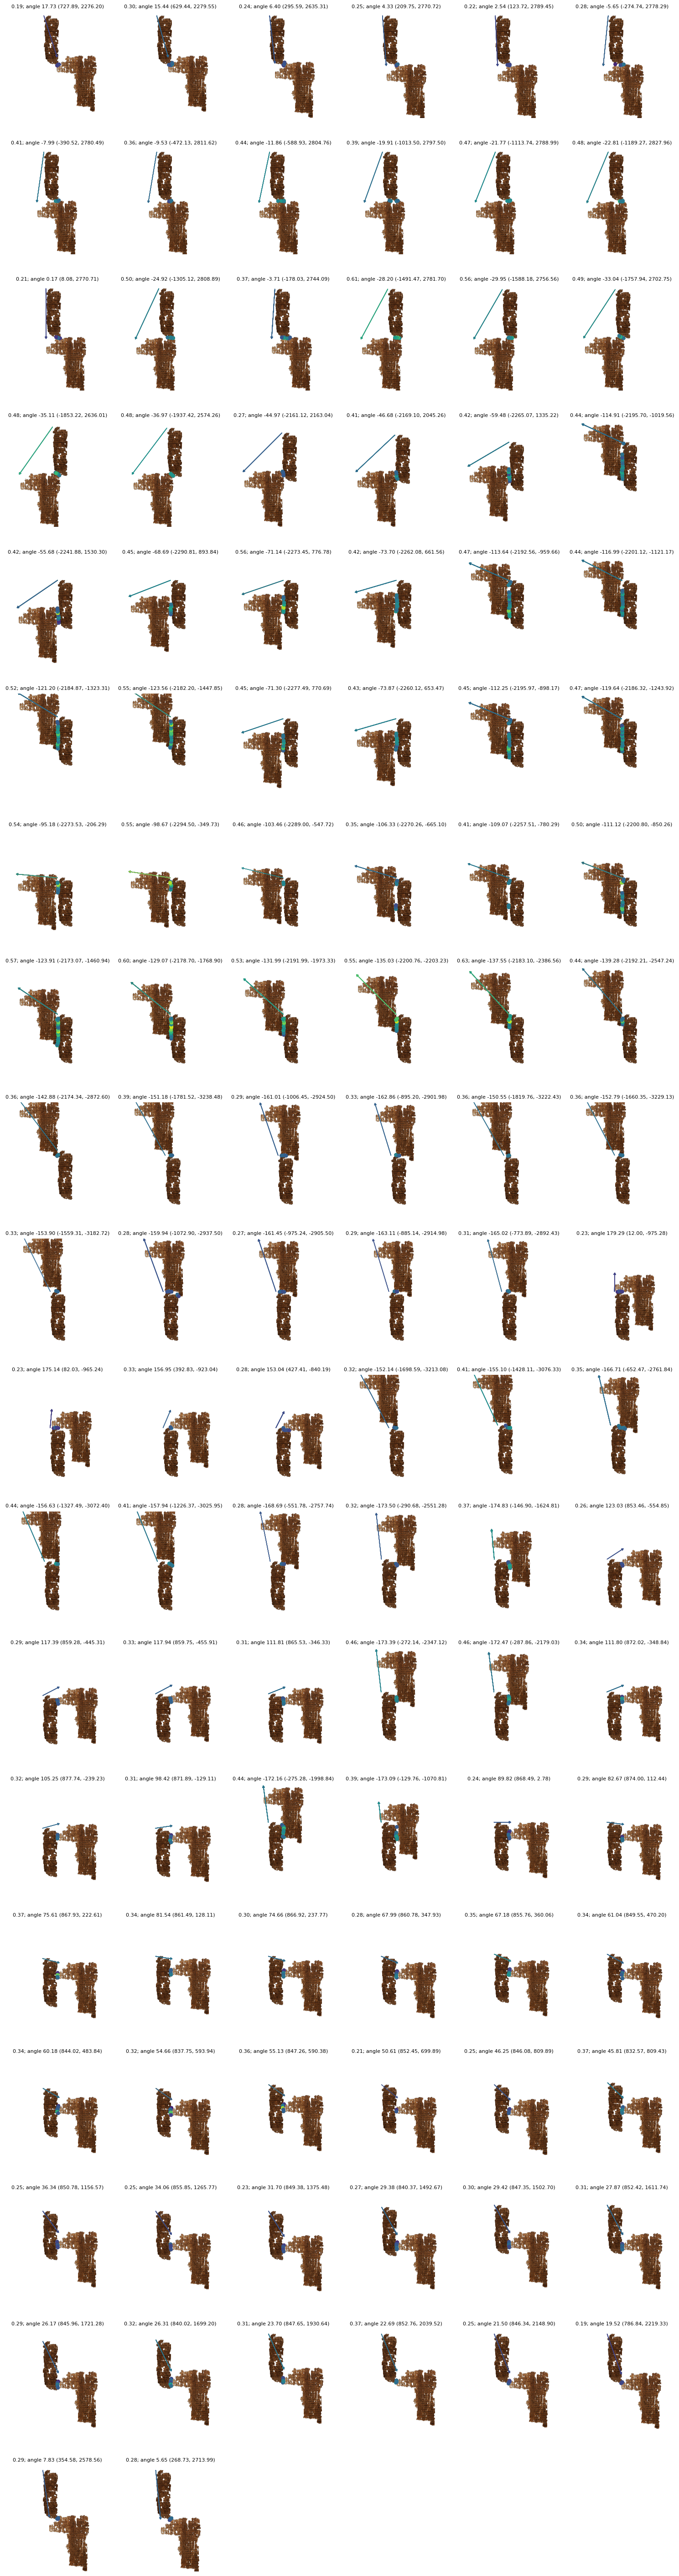

In [7]:
# show images organizing them in a grid
fig = plt.figure(figsize=(15, 60))
num_samples = min(120, len(dset))

for i in tqdm.trange(num_samples):
    start = time.time()
    data = dset[i]
    end_loading = time.time()
    patches, image = data

    image, t_a_full, _, _ = image

    patches_imgs, t_a_patches, t_relatives, middle_points, _, _ = zip(*patches)
    patches_imgs = torch.stack(patches_imgs).to(device)

    scores = encoder(patches_imgs)
    with torch.no_grad():
        scores = torch.sigmoid(scores).cpu()
    end_inference = time.time()
    # print(f"Loading time: {end_loading - start:.3f}s, Inference time: {end_inference - end_loading:.3f}s")

    ax = fig.add_subplot(20, 6, i + 1)
    # disable axis
    ax.axis('off')
    image_np = image
    t_relative = t_relatives[0]
    for score, mp in zip(scores, middle_points):
        color = plt.cm.viridis(score)
        # draw red_dots at the center of the full_image
        center = mp + t_a_full
        rr, cc = draw.disk(center, 110, shape=image_np.shape[:2])
        image_np[rr, cc] = (color[:3] * 255).astype(np.uint8)
        image_np[rr, cc, 3] = 255 # set alpha to 255

        # draw displacement vector
        y_start, x_start = t_a_full
        y_end, x_end = t_relative + t_a_full
        ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, head_width=110, head_length=100, fc=color[:3], ec=color[:3], alpha=0.6)
    angle = np.degrees(np.arctan2(t_relative[1], t_relative[0]))
    pooled_score = scores.mean()
    ax.set_title(f"{pooled_score:.2f}; angle {angle:.2f} ({t_relative[1]:.2f}, {t_relative[0]:.2f})", fontdict={'size': 8})
    ax.imshow(image_np)

# save figure
plt.tight_layout()
# plt.savefig("inference_results.png", dpi=300)


In [9]:
# show images organizing them in a grid
num_samples = len(dset) # min(100, len(dset))

t_relatives_all = []
scores_all = []

for i in tqdm.trange(num_samples):
    start = time.time()
    data = dset[i]
    end_loading = time.time()
    patches, image = data

    image, t_a_full, _, _ = image

    patches_imgs, t_a_patches, t_relatives, middle_points, _, _ = zip(*patches)
    patches_imgs = torch.stack(patches_imgs).to(device)

    scores = encoder(patches_imgs)
    with torch.no_grad():
        scores = torch.sigmoid(scores).cpu()
    end_inference = time.time()
    # print(f"Loading time: {end_loading - start:.3f}s, Inference time: {end_inference - end_loading:.3f}s")

    assert all([(t_relatives[i] == t_relatives[i+1]).all() for i in range(len(t_relatives)-1)])
    t_relatives_all.append(t_relatives[0])
    scores_all.append(scores)

100%|██████████| 110/110 [13:02<00:00,  7.11s/it]


In [10]:
root = 'data/toy_fragments'
image_name_a = root + "/test_fragment_easy1_L_back.png"
image_name_b = root + "/test_fragment_easy1_R_back.png" # "/test_fragment_hard1_L.png"

from torchvision import transforms as T
transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
mask_transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
dset_back = InferenceDataset(image_name_a, image_name_b, pad=20, perimeter_points_distance=128, transform=transf, mask_transform=mask_transf, return_final_image=True)

In [11]:
# show images organizing them in a grid
num_samples = len(dset_back) # min(100, len(dset))

t_relatives_all_back = []
scores_all_back = []

for i in tqdm.trange(num_samples):
    start = time.time()
    data = dset_back[i]
    end_loading = time.time()
    patches, image = data

    image, t_a_full, _, _ = image

    patches_imgs, t_a_patches, t_relatives, middle_points, _, _ = zip(*patches)
    patches_imgs = torch.stack(patches_imgs).to(device)

    scores = encoder(patches_imgs)
    with torch.no_grad():
        scores = torch.sigmoid(scores).cpu()
    end_inference = time.time()
    # print(f"Loading time: {end_loading - start:.3f}s, Inference time: {end_inference - end_loading:.3f}s")

    assert all([(t_relatives[i] == t_relatives[i+1]).all() for i in range(len(t_relatives)-1)])
    t_relatives_all_back.append(t_relatives[0])
    scores_all_back.append(scores)

100%|██████████| 136/136 [13:55<00:00,  6.15s/it]


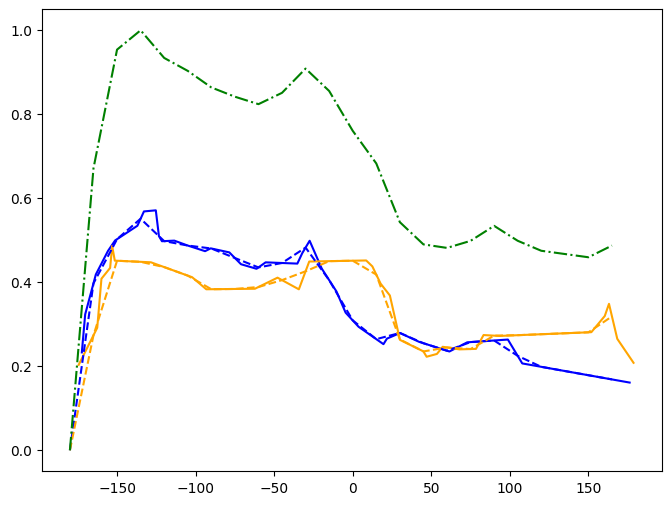

In [9]:
def compute_angles_and_scores(t_relatives_in, scores_in, back=False):
    angles_l = []
    scores_l = []
    for t_rel, scores in zip(t_relatives_in, scores_in):
        angle = np.degrees(np.arctan2(t_rel[1], t_rel[0])) # x, y and not y, x because I want angle with respect to y axis
        if back:
            angle = -angle
        score = scores.mean().item()
        angles_l.append(angle)
        scores_l.append(score)

    # sort (angle, score) by angle
    angles_l = np.array(angles_l)
    scores_l = np.array(scores_l)
    sorted_indices = np.argsort(angles_l)
    angles_l = angles_l[sorted_indices]
    scores_l = scores_l[sorted_indices]

    # apply a moving average filter to scores_l
    window_size = 5
    scores_l = np.convolve(scores_l, np.ones(window_size)/window_size, mode='same')

    return angles_l, scores_l

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
angles_l, scores_l = compute_angles_and_scores(t_relatives_all, scores_all)
angles_l_back, scores_l_back = compute_angles_and_scores(t_relatives_all_back, scores_all_back, back=True)

ax.plot(angles_l, scores_l, label='Front Side', color='blue')
ax.plot(angles_l_back, scores_l_back, label='Back Side', color='orange')

common_angles = np.arange(-180, 180, 15) 

# 3. Interpolate both datasets onto this common grid
# np.interp(new_x_points, known_x_points, known_y_points)
interp_scores_l = np.interp(
    common_angles, 
    angles_l, 
    scores_l,
    left=0,  # Value to use for angles < min(sorted_angles_l)
    right=0  # Value to use for angles > max(sorted_angles_l)
)

interp_scores_back = np.interp(
    common_angles, 
    angles_l_back, 
    scores_l_back,
    left=0,  # Value to use for angles < min(sorted_angles_back)
    right=0  # Value to use for angles > max(sorted_angles_back)
)

ax.plot(common_angles, interp_scores_l, label='Front Side Interp.', color='blue', linestyle='--')
ax.plot(common_angles, interp_scores_back, label='Back Side Interp.', color='orange', linestyle='--')

sum = interp_scores_l + interp_scores_back
ax.plot(common_angles, sum, label='Sum', color='green', linestyle='-.')

Position (xy): (-2030.1503329899344, -1360.7739738608384) Score: 1.1075861556147273 Angle: -123.83324983759206
Position (xy): (-2030.1503329899344, -1505.213058396942) Score: 1.0851477188689498 Angle: -126.55432315281539
Position (xy): (-2030.1503329899344, -1794.0912274691493) Score: 1.0818406933349918 Angle: -131.4677828540237
Position (xy): (-1765.796929650689, -1360.7739738608384) Score: 1.071930791516016 Angle: -127.61888198045486
Position (xy): (-2030.1503329899344, -1649.6521429330455) Score: 1.056373559317695 Angle: -129.09649372226772
Discrepancy recto-verso: 0.056446138154409256


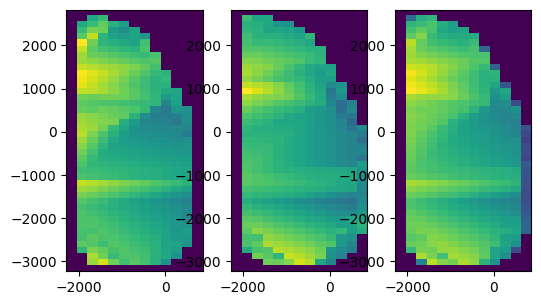

In [12]:
def compute_positions_and_scores(grid, t_relatives_in, scores_in):
    pos_l = []
    scores_l = []
    for t_rel, scores in zip(t_relatives_in, scores_in):
        score = scores.mean().item()
        pos_l.append(t_rel)
        scores_l.append(score)

    # interpolate
    interp_l_scores = griddata(
        pos_l,    
        scores_l, 
        grid,
        method='linear', 
        fill_value=0)
    
    # if back:
    #     interp_l_scores = interp_l_scores.reshape((samples[1], samples[0]))[:, ::-1].flatten()  # TODO: qualcosa non va, funziona se flippo l'asse y

    return interp_l_scores

image = io.imread(image_name_a)
image_size = image.shape[:2]  # Get height and width
patch_size = (64, 64)
samples = (image_size[0] // patch_size[0], image_size[1] // patch_size[1])  # Number of samples in y and x

# 1. Define your Common Grid to use for interpolation
min_y = min([t_rel[0] for t_rel in t_relatives_all])
max_y = max([t_rel[0] for t_rel in t_relatives_all])
min_x = min([t_rel[1] for t_rel in t_relatives_all])
max_x = max([t_rel[1] for t_rel in t_relatives_all])
grid_x_coords = np.linspace(min_x, max_x, samples[1])
grid_y_coords = np.linspace(min_y, max_y, samples[0])
grid_y, grid_x = np.meshgrid(grid_y_coords, grid_x_coords, indexing='ij')
grid = np.vstack([grid_y.ravel(), grid_x.ravel()]).T

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1, 3, 1)
scores_l = compute_positions_and_scores(grid, t_relatives_all, scores_all)
# show a 2D heatmap of the scores
scores_grid = scores_l.reshape((samples[0], samples[1]))
# flip x and y for correct orientation
extent = grid[:, 1].min(), grid[:, 1].max(), grid[:, 0].min(), grid[:, 0].max()
ax1.imshow(scores_grid, extent=extent, cmap='viridis')

ax2 = fig.add_subplot(1, 3, 2)
scores_l_back = compute_positions_and_scores(grid, t_relatives_all_back, scores_all_back)
# show a 2D heatmap of the scores
scores_grid_back = scores_l_back.reshape((samples[0], samples[1]))
scores_grid_back = scores_grid_back[:, ::-1]  # flip for the verso to match the recto.
ax2.imshow(scores_grid_back, extent=extent, cmap='viridis')

ax3 = fig.add_subplot(1, 3, 3)
sum_scores_grid = scores_grid + scores_grid_back
# show a 2D heatmap of the scores
ax3.imshow(sum_scores_grid, extent=extent, cmap='viridis')

discrepancy_recto_verso = np.abs(scores_grid - scores_grid_back)
discrepancy_recto_verso = discrepancy_recto_verso[discrepancy_recto_verso != 0].mean()

# find the coordinates of the top-k maximums in sum_scores_grid
k = 5
flat_indices = np.argsort(sum_scores_grid.ravel())[-k:][::-1]
y_indices, x_indices = np.unravel_index(flat_indices, sum_scores_grid.shape)
for y_idx, x_idx in zip(y_indices, x_indices):
    angle = np.degrees(np.arctan2(grid_x_coords[x_idx], grid_y_coords[y_idx]))
    print("Position (xy):", (grid_x_coords[x_idx], grid_y_coords[y_idx]), "Score:", sum_scores_grid[y_idx, x_idx], "Angle:", angle)

print("Discrepancy recto-verso:", discrepancy_recto_verso)